In [1]:
using JuMP, Ipopt, Plots

Consider the continuous stirred-tank reactor with reactions $A + B \rightarrow C$ and $2B \rightarrow D$

$C_A$ balance: 
$\dfrac{d C_A(t)}{d t} = \dfrac{u_A(t)}{V}C_{A,in} - \dfrac{u_A(t) + u_B(t)}{V}C_A(t) - k_1 C_A(t) C_B(t) $

$C_B$ balance:$\dfrac{d C_B(t)}{d t} = \dfrac{u_B(t)}{V}C_{B,in} - \dfrac{u_A(t) + u_B(t)}{V}C_B(t) - k_1 C_A(t) C_B(t) -2k_2C_B(t)^2 $

$C_C$ Balance:
$\dfrac{d C_C(t)}{d t} = - \dfrac{u_A(t) + u_B(t)}{V}C_C(t) + k_1 C_A(t) C_B(t)$

$C_D$ Balance: 
$\dfrac{d C_D(t)}{d t} = - \dfrac{u_A(t) + u_B(t)}{V}C_D(t) + k_2C_B(t)^2 $

Generated heat: 
$ Q(t) = -V(k_1C_A(t)C_B(t) \Delta H_{r,1} + k_2 C_B(t)^2 \Delta H_{r,2}) $

Molar fraction of D:
$ M_D(t) = \dfrac{C_D(t)}{(C_A(t) + C_B(t) + C_C(t) + C_D(t)} $

where, $C_X$ denotes the concentration of species $X$, $V$ is the reactor volume, $u_A$ and $u_B$ are the feed rates of $A$ and $B$, $Q$ is the power generated by the chemical reactions, $\Delta H_{r,1}$ and $\Delta H_{r,2}$ are the reaction enthalpies of the two exothermic reactions, $k_1$ and $k_2$ are the rate constants of the two chemical reactions, and $M_D$ is the molar fraction of the $D$.

In [2]:
# System parameters
nc = 4          # [-] number of components
nu = 2          # [-] number of inputs

# Model parameters
k1 = 0.75       # [L/(mol min)] reaction 1 constant
k2 = 1.5        # [L/(mol min)] reaction 2 constant
caIn = 2        # [mol/L] A inlet concentration
cbIn = 1.5      # [mol/L] B inlet concentration
V = 500         # [L] reactor volume
DHr1 = -3.5     # [kcal/mol] reaction 1 enthalpy
DHr2 = -1.5     # [kcal/mol] reaction 2 enthalpy

# Optimization parameters
w = 0.004       # [L^2/mol^2] input usage penalty
QMax = 110      # [kcal/min] maximal heat generation
dMax = 0.12     # [-] maximal molar fraction of D
uMin = [0, 0]      # [L/min] maximum input flowrate
uMax = [50, 50];       # [L/min] maximum input flowrate

In [3]:
# Parameters for orthogonal collocation
nfe    = 25          # number of control intervals (finite elements)
ncp    = 3           # number of collocation points
th     = 50          # time horizon
h      = th/nfe      # length of one finite element on the time horizon

# Collocation parameters and radau time series
#N = M^-1 =
colmat = [0.19681547722366  -0.06553542585020 0.02377097434822;
          0.39442431473909  0.29207341166523 -0.04154875212600;
          0.37640306270047  0.51248582618842 0.11111111111111]
radau  = [0.15505 0.64495 1.00000];

In [4]:
# Initial conditions
#calculated with REactorModel.jl
c0 = [0.5298597648508452,0.06151889952652645,0.4701402351491549,0.10917043266215933]
u0 = [13,13]

# time series for plotting
ts     = Vector{Float64}(undef,nfe) 
for i in 1:nfe
    ts[i] = h*i
end

We want to solve a dynamic optimization problem to try to maximize the outlet flow of $C$ while taking into account a penalization for the control effort (using the tuning parameter $w$). We also use a convexified function of the objective function.

$\underset{u_A,u_B}{\max} \quad \int_{0}^{T} \bigg[ \bigg(C_C(t)(u_A(t) + u_B(t)) \bigg)^2 - w \ (u_A(t) + u_B(t))^2 \bigg] d t $ 

subject to:

$ C(0)  = C_0 $ <br>
$ \dot{C}(t) = f(C(t),u_A(t),u_B(t)) \quad t \in [0, T] $ <br>
$Q(t) \leq Q_{max}        \quad t \in [0, T] $ <br>
$M_D(t) \leq M_{D,max}    \quad  t \in [0, T] $ <br>
$ 0 \leq u_A(t), u_B(t) \leq u_max  \quad t \in [0, T] $ <br>

In [5]:
# JuMP model
m = Model(Ipopt.Optimizer)
set_optimizer_attribute(m, "warm_start_init_point", "yes")
set_optimizer_attribute(m, "print_level", 5)

# Set up variables
@variables(m, begin
    c[1:nc, 1:nfe, 1:ncp]            # [mol/L] concentration (states)
    cdot[1:nc, 1:nfe, 1:ncp]         # [mol/L/min]
    uMin[1] <= u1[1:nfe] <= uMax[1]  # [L/min] inlet flowrates
    uMin[2] <= u2[1:nfe] <= uMax[2]  # [L/min] inlet flowrates
end)

# Set up initial guesses for solver
for i in 1:nfe
    for j in 1:ncp
        set_start_value(c[1,i,j], c0[1])    #C_A
        set_start_value(c[2,i,j], c0[2])    #C_B
        set_start_value(c[3,i,j], c0[3])    #C_C
        set_start_value(c[4,i,j], c0[4])    #C_D
    end

    set_start_value(u1[i], u0[1])      #F_A
    set_start_value(u2[i], u0[2])      #F_B
end

# Set up objective function  
@NLobjective(m, Min, -sum(h*(sum(
                                (
                                (c[3,i,j]^2*(u1[i] + u2[i])^2) - w*(u1[i]^2 + u2[i]^2) 
                                )*colmat[ncp,j]
                                for j in 1:ncp
                               )
                           ) for i in 1:nfe
                        )
            )

@NLexpressions(m, begin
    # [kcal/min] generated heat
    Q[i=1:nfe], -V*(k1*c[1,i,ncp]*c[2,i,ncp]*DHr1 + k2*c[2,i,ncp]^2*DHr2)
    #[-] molar fraction of D
    D[i=1:nfe], c[4,i,ncp]/(sum(c[l,i,ncp] for l in 1:nc))
end)

#Set up the constraints
@NLconstraints(m, begin
    # set up differential equations
    m1[i=1:nfe, j=1:ncp], cdot[1,i,j] == -k1*c[1,i,j]*c[2,i,j] + u1[i]*caIn/V - (u1[i] + u2[i])*c[1,i,j]/V
    m2[i=1:nfe, j=1:ncp], cdot[2,i,j] == -k1*c[1,i,j]*c[2,i,j] - 2*k2*c[2,i,j]^2 + u2[i]*cbIn/V - (u1[i] + u2[i])*c[2,i,j]/V
    m3[i=1:nfe, j=1:ncp], cdot[3,i,j] == k1*c[1,i,j]*c[2,i,j]  - (u1[i] + u2[i])*c[3,i,j] /V
    m4[i=1:nfe, j=1:ncp], cdot[4,i,j] == k2*c[2,i,j]^2 - (u1[i] + u2[i])*c[4,i,j]/V
    # set up collocation equations - 2nd-to-nth point
    coll_c_n[l=1:nc, i=2:nfe, j=1:ncp], c[l,i,j] == c[l,i-1,ncp]+h*sum(colmat[j,k]*cdot[l,i,k] for k in 1:ncp)
    # set up collocation equations - 1st point
    coll_c_0[l=1:nc, i=[1], j=1:ncp], c[l,i,j] == c0[l] +h*sum(colmat[j,k]*cdot[l,i,k] for k in 1:ncp)
    # set up constraints
    g1[i=1:nfe], Q[i]/QMax - 1 <= 0
    g2[i=1:nfe], D[i]/dMax - 1 <= 0
    end);

In [6]:
# Solve the model
solveNLP = JuMP.optimize!
status = solveNLP(m)

# Get values for plotting
res = Matrix{Float64}(undef,nc,nfe) # time series for plotting
for i in 1:nc
    res[i,:] = JuMP.value.(c[i,:,3])
end

uStar1 = JuMP.value.(u1) # time series for plotting
uStar2 = JuMP.value.(u2) # time series for plotting
QStar = JuMP.value.(Q); # time series for plotting
#PhiStar =(res[3,:].^2 .*(uStar1 + uStar2)).^2 ./(uStar1 .*caIn) - w*(uStar1 .^2 + uStar2 .^2)




******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.14.4, running with linear solver MUMPS 5.4.1.

Number of nonzeros in equality constraint Jacobian...:     3063
Number of nonzeros in inequality constraint Jacobian.:      150
Number of nonzeros in Lagrangian Hessian.............:     3025

Total number of variables............................:      650
                     variables with only lower bounds:        0
                variables with lower and upper bounds:       50
                     variables with only upper bounds:        0
Total number of equality constraints.................:      600
Total number of inequality co

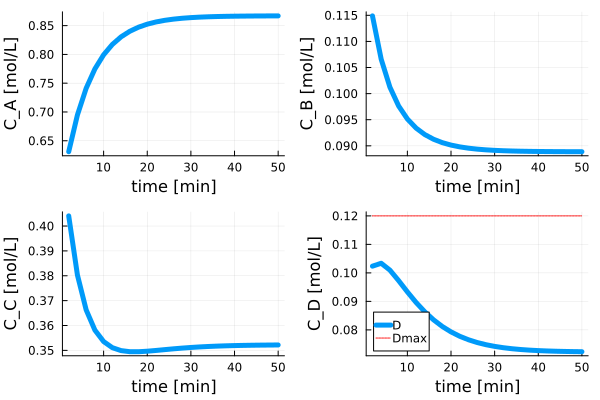

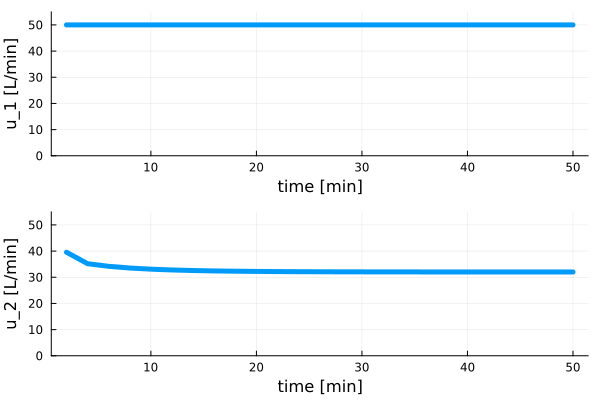

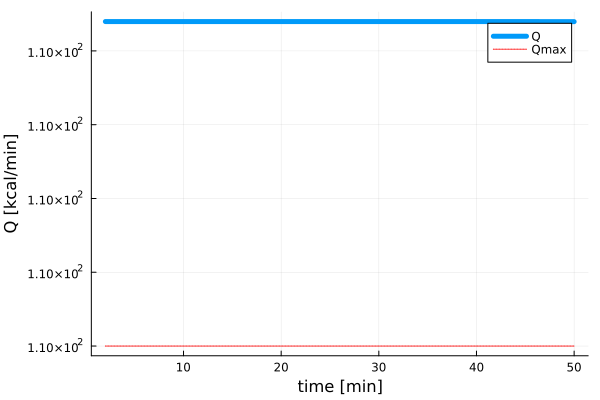

In [7]:
gr()

# C_A
p11 = plot(ts,res[1,:],linewidth=5,xaxis="time [min]",yaxis="C_A [mol/L]",legend=false)
# C_B
p12 = plot(ts,res[2,:],linewidth=5,xaxis="time [min]",yaxis="C_B [mol/L]",legend=false)
#C_C
p13 = plot(ts,res[3,:],linewidth=5,xaxis="time [min]",yaxis="C_C [mol/L]",legend=false)
#C_D
p14 = plot(ts,res[4,:],linewidth=5,xaxis="time [min]",yaxis="C_D [mol/L]")
p14 = plot!(ts,dMax .*ones(length(ts)),linestyle = :dot,linecolor = :red)
p14.series_list[1][:label] = "D"
p14.series_list[2][:label] = "Dmax"

g1 = plot(p11,p12,p13,p14,layout=(2,2))
display(g1)

p21 = plot(ts,uStar1[:],linewidth=5,xaxis="time [min]",yaxis="u_1 [L/min]",ylims = (0, uMax[1] + 5))
p22 = plot(ts,uStar2[:],linewidth=5,xaxis="time [min]",yaxis="u_2 [L/min]",ylims = (0, uMax[2] + 5))

g2 = plot(p21,p22,layout=(2,1),legend=false)
display(g2)

g3 = plot(ts,QStar,linewidth=5,xaxis="time [min]",yaxis="Q [kcal/min]")
g3 = plot!(ts,QMax .*ones(length(ts)),linestyle = :dot,linecolor = :red)
g3.series_list[1][:label] = "Q"
g3.series_list[2][:label] = "Qmax"
display(g3)